In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using CUDA, CUDA.CUBLAS, CUDA.CUSOLVER, CUDA.CUSPARSE
using BenchmarkTools

In [2]:
# Functions 
# System Equation Linear Sparse
function system_matrix_sparse(systemDimension::Integer, matrixA::AbstractMatrix)
    vectorDiagonalMain = 3 * ones(systemDimension)
    vectorDiagonalUpperLower = -1 * ones(systemDimension - 1)
    matrixA .= convert(Matrix, Tridiagonal(vectorDiagonalUpperLower, vectorDiagonalMain, vectorDiagonalUpperLower))
    for i = 1:systemDimension
        if matrixA[i, systemDimension-i+1] == 0.0
            matrixA[i, systemDimension-i+1] = 0.5
        end
    end
    return nothing
end
# 
function vector_independent_term(systemDimension::Integer, vectorB::AbstractVector)
    vectorB[1] = 2.5
    vectorB[systemDimension] = 2.5
    position::Integer = floor(systemDimension / 2)
    for i = 2:systemDimension-1
        if i == position || i == position + 1
            vectorB[i] = 1.0
        else
            vectorB[i] = 1.5
        end
    end
    return nothing
end

vector_independent_term (generic function with 1 method)

In [183]:
N = 128
tA = Matrix{Float64}(undef, N, N)
b = Vector{Float64}(undef, N)
x_0 = zeros(N);
system_matrix_sparse(N, tA)
vector_independent_term(N, b);
A = sparse(tA)
modulo = 8
precondicionador = "SOR"

"SOR"

In [166]:
function cgm_sparse(A::SparseMatrixCSC{Float64,Int64}, b::AbstractVector, ϵ=1e-5)

    x_c = zeros(length(b))
    r_c = b - A * x_c
    d_c = r_c
    normres_cgm = []

    for k = 1:45
        vectorAD = A * d_c
        alpha = dot(r_c, r_c) / dot(vectorAD, d_c)
        x_n = x_c + alpha * d_c
        # normres_cgm = [normres_cgm;norm(b-A*x_n)]
        # Stop Condition
        # methodError = norm(x_n - vectorX_exactSolution) / norm(x_n)
        # if methodError <= tolerance
        #     iterationNumber = k
        #     break
        # end
        r_n = r_c - alpha * vectorAD
        normres_cgm = [normres_cgm;norm(r_n)]
        beta = dot(r_n, r_n) / dot(r_c, r_c)
        d_n = r_n + beta * d_c
        # Update
        x_c = x_n
        r_c = r_n
        d_c = d_n
    end

    return normres_cgm
end

cgm_sparse (generic function with 2 methods)

In [167]:
function cgm_precondicionado_sparse(A::SparseMatrixCSC{Float64,Int64}, b::AbstractVector, precondicionador::String, ϵ=1e-5)

    D = Diagonal(A)
    U = triu(A, 1)
    L = tril(A, -1)
    α = 1.2

    if precondicionador == "Jacobi"
        Ms = [D]
    end
    if precondicionador == "SOR"
        M_sor_1 = I + (α * L * inv(D))
        M_sor_2 = D + α * U
        Ms = [M_sor_1, M_sor_2]
    end

    x_c = zeros(length(b))
    r_c = b - A * x_c
    z = r_c
    [z = M \ z for M ∈ Ms]
    d_c = z
    normres_cgm = []

    for k = 1:45
        Ad = A * d_c
        alpha = dot(r_c, z) / dot(Ad, d_c)
        x_n = x_c + alpha * d_c
        r_n = r_c - alpha * Ad
        normres_cgm = [normres_cgm; norm(r_n)]
        z_next = r_n
        [z_next = M \ z_next for M ∈ Ms]
        beta = dot(r_n, z) / dot(r_c, z)
        d_n = z_next + beta * d_c
        # Update
        x_c = x_n
        r_c = r_n
        d_c = d_n
        z = z_next
    end

    return normres_cgm
end

cgm_precondicionado_sparse (generic function with 2 methods)

In [184]:
function leastsquares(H, r)
    r′ = zeros(size(H)[1])
    r′[1] = norm(r)
    x = H \ r′
end

function gmres(A::SparseMatrixCSC{Float64, Int64}, b::Vector{Float64}, ϵ = 1e-5)
    x₀ = zeros(length(b))
    residual₀ = b - A*x₀
    q = [residual₀ / norm(residual₀)]
    normres_gmres = []

    k = 1
    x = x₀
    H = zeros(2,1)
    residual = residual₀
    counter = 0
    while norm(residual) > ϵ
    # while k <= 40
        y = A*q[k]
        for j ∈ 1:k
            H[j,k] = q[j]' * y
            y -= H[j,k]*q[j]
        end
        H[k+1,k] = norm(y)
        normres_gmres = [normres_gmres;H[k+1,k]]
        if H[k+1,k] < ϵ
            break;
        end
        push!(q, y/H[k+1,k])
        H = vcat(H, zeros(1, size(H)[2]))
        H = hcat(H, zeros(size(H)[1], 1))
        if k % 40 == 0
            c = leastsquares(H, residual₀)
            Q = hcat(q...)
            x = Q*c + x₀
            residual = A*x - b
        end
        k += 1
        counter+=1
    end

    normres_gmres = [normres_gmres;norm(residual)]
    return normres_gmres
end

gmres (generic function with 2 methods)

In [199]:
normres_gmres = gmres(A,b)

41-element Vector{Any}:
 0.31069629783584124
 0.9775676880400933
 1.1276778440192872
 1.1200412814676435
 1.0609544930622337
 1.0229054919465435
 1.0073820413831496
 1.00197923596631
 1.0001783358606708
 0.999564040552603
 ⋮
 1.651496219474228
 1.12100909919046
 0.8522665871348225
 0.9490665772067174
 0.9891502597269786
 1.0096828637630955
 1.076505177518402
 1.3293217969375493
 1.0920893191864011e-14

In [209]:
function leastsquares(H, r)
    r′ = zeros(size(H)[1])
    r′[1] = norm(r)
    x = H \ r′
end

function gmresreiniciado(A::SparseMatrixCSC{Float64, Int64}, b::Vector{Float64}, ϵ = 1e-5)
    x₀ = zeros(length(b))
    residual₀ = b - A*x₀
    q = [residual₀ / norm(residual₀)]
    normres_gmresrei = []

    k = 1
    x = x₀
    H = zeros(2,1)
    residual = residual₀
    counter = 0
    while norm(residual) > ϵ
        y = A*q[k]
        for j ∈ 1:k
            H[j,k] = q[j]' * y
            y -= H[j,k]*q[j]
        end
        H[k+1,k] = norm(y)
        push!(q, y/H[k+1,k])
        H = vcat(H, zeros(1, size(H)[2]))
        H = hcat(H, zeros(size(H)[1], 1))
        k += 1
        if k % modulo == 0 
            c = leastsquares(H, residual₀)
            Q = hcat(q...)
            x = Q*c + x₀
            residual = A*x - b
            counter+=1
            x₀, residual₀, q, k, H = reiniciarvariables(x, A, b)
        end
        normres_gmresrei = [normres_gmresrei;norm(residual₀)]
    end
    return normres_gmresrei
end


function reiniciarvariables(x, A, b)
    k = 1
    x₀ = x
    r = b - A*x₀
    H = zeros(2,1)
    q = [r / norm(r)]
    return x₀, r, q, k, H
end


function obtenermodulo(dims)
    if dims == 10
        modulo = 15
    elseif dims == 20
        modulo = 20
    elseif dims == 30
        modulo = 35
    elseif dims == 40
        modulo = 25
    elseif dims == 50
        modulo = 15
    elseif dims == 60
        modulo = 15
    elseif dims == 80
        modulo = 30
    elseif dims == 100
        modulo = 35
    end
    return modulo
end

obtenermodulo (generic function with 1 method)

In [210]:
normres_gmresrei = gmresreiniciado(A,b)

14-element Vector{Any}:
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
  0.0048117948466752285
  0.0048117948466752285
  0.0048117948466752285
  0.0048117948466752285
  0.0048117948466752285
  0.0048117948466752285
  0.0048117948466752285
  3.27775218083246e-6

In [232]:
function precondition(name, A, b)
    if name == "Jacobi"
        M_jacobi = Diagonal(A)
        return [M_jacobi]

    elseif name == "Gauss-Seidel"
        D = Diagonal(A)
        U = triu(A,1) 
        L = tril(A,-1)
        M_gauss_seidel_1 = I+(L*inv(D))
        M_gauss_seidel_2 = D+U
        return [M_gauss_seidel_1, M_gauss_seidel_2]

    elseif name == "SOR"
        α = 1.8
        D = Diagonal(A)
        U = triu(A,1) 
        L = tril(A,-1)
        M_sor_1 = I+(α*L*inv(D))
        M_sor_2 = D+α*U
        return [M_sor_1, M_sor_2]
    end
end


function gmresprecondicionado(A::SparseMatrixCSC{Float64, Int64}, b::Vector{Float64}, precondition_name::String, ϵ = 1e-10)
    Ms = precondition(precondition_name, A, b)

    x₀ = rand(length(b))
    residual₀ = (b - A*x₀)
    [residual₀ = M\residual₀ for M ∈ Ms]
    q = [residual₀ / norm(residual₀)]
    normres_gmrespre = []

    k = 1
    x = x₀
    H = zeros(2,1)
    residual = residual₀
    counter = 0
    while norm(residual) > ϵ
        ω = A*q[k]
        [ω = M\ω for M ∈ Ms]
        for j ∈ 1:k
            H[j,k] = q[j]' * ω
            ω -= H[j,k]*q[j]
        end
        H[k+1,k] = norm(ω)
        push!(q, ω/H[k+1,k])
        H = vcat(H, zeros(1, size(H)[2]))
        H = hcat(H, zeros(size(H)[1], 1))
        if k % 40 == 0
            c = leastsquares(H, residual₀)
            Q = hcat(q...)
            x = Q*c + x₀
            residual = A*x - b
            [residual = M\residual for M ∈ Ms]
        end
        normres_gmrespre = [normres_gmrespre;norm(residual)]
        k += 1
        counter+=1
    end
    return normres_gmrespre
    # return normres_gmrespre, x
end

gmresprecondicionado (generic function with 2 methods)

In [11]:
normres_gmrespre = gmresprecondicionado(A,b,precondicionador)

20-element Vector{Any}:
 44.54676540295609
 44.54676540295609
 44.54676540295609
 44.54676540295609
 44.54676540295609
 44.54676540295609
 44.54676540295609
 44.54676540295609
 44.54676540295609
  0.00041839268831684364
  0.00041839268831684364
  0.00041839268831684364
  0.00041839268831684364
  0.00041839268831684364
  0.00041839268831684364
  0.00041839268831684364
  0.00041839268831684364
  0.00041839268831684364
  0.00041839268831684364
  8.509542493968195e-9

In [211]:
function precondition(name, A, b)
    if name == "Jacobi"
        M_jacobi = Diagonal(A)
        return [M_jacobi]

    elseif name == "Gauss-Seidel"
        D = Diagonal(A)
        U = triu(A,1) 
        L = tril(A,-1)
        M_gauss_seidel_1 = I+(L*inv(D))
        M_gauss_seidel_2 = D+U
        return [M_gauss_seidel_1, M_gauss_seidel_2]

    elseif name == "SOR"
        α = 1.13
        D = Diagonal(A)
        U = triu(A,1) 
        L = tril(A,-1)
        M_sor_1 = I+(α*L*inv(D))
        M_sor_2 = D+α*U
        return [M_sor_1, M_sor_2]
    end
end

function gmresprecondicionadoreiniciado(A::AbstractMatrix, b::Vector{Float64}, precondition_name::String, ϵ = 1e-10)
    x₀ = zeros(length(b))
    Ms = precondition(precondition_name, A, b)
    residual₀ = b - A*x₀
    [residual₀ = M\residual₀ for M ∈ Ms]
    q = [residual₀ / norm(residual₀)]
    normres_gmresreipre = []

    k = 1
    x = x₀
    H = zeros(2,1)
    residual = residual₀
    counter = 0
    while norm(residual) > ϵ
        ω = A*q[k]
        [ω = M\ω for M ∈ Ms]
        for j ∈ 1:k
            H[j,k] = q[j]' * ω
            ω -= H[j,k]*q[j]
        end
        H[k+1,k] = norm(ω)
        push!(q, ω/H[k+1,k])
        H = vcat(H, zeros(1, size(H)[2]))
        H = hcat(H, zeros(size(H)[1], 1))
        k += 1
        if k % modulo == 0
            c = leastsquares(H, residual₀)
            Q = hcat(q...)
            x = Q*c + x₀
            residual = A*x - b
            [residual = M\residual for M ∈ Ms]
            x₀, residual₀, q, k, H = reiniciarvariablesprecondicionado(x, A, b, Ms)
        end
        normres_gmresreipre = [normres_gmresreipre;norm(residual₀)]
        counter+=1
    end
    return normres_gmresreipre
end

function reiniciarvariablesprecondicionado(x::Vector, A::AbstractMatrix, b::Vector{Float64}, Ms::Vector)
    k = 1
    x₀ = x
    H = zeros(2,1) 
    residual₀ = b - A*x₀
    [residual₀ = M\residual₀ for M ∈ Ms]
    q = [residual₀ / norm(residual₀)]
    return x₀, residual₀, q, k, H
end

reiniciarvariablesprecondicionado (generic function with 1 method)

In [13]:
normres_gmresprerei = gmresprecondicionadoreiniciado(A,b,precondicionador)

7-element Vector{Any}:
 43.38064397454105
 43.38064397454105
 43.38064397454105
 43.38064397454105
 43.38064397454105
 43.38064397454105
  1.6505303532828427e-6

In [214]:
norm_cgm = cgm_sparse(A,b)
norm_gmres = gmres(A,b,1e-13)
display(norm_gmres)
norm_gmres_reiniciado = gmresreiniciado(A,b, 1e-13);
display(norm_gmres_reiniciado)

41-element Vector{Any}:
 0.31069629783584124
 0.9775676880400933
 1.1276778440192872
 1.1200412814676435
 1.0609544930622337
 1.0229054919465435
 1.0073820413831496
 1.00197923596631
 1.0001783358606708
 0.999564040552603
 ⋮
 1.651496219474228
 1.12100909919046
 0.8522665871348225
 0.9490665772067174
 0.9891502597269786
 1.0096828637630955
 1.076505177518402
 1.3293217969375493
 1.0920893191864011e-14

35-element Vector{Any}:
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
  0.0048117948466752285
  0.0048117948466752285
  0.0048117948466752285
  0.0048117948466752285
  ⋮
  2.8881957124155764e-9
  2.7143567817030196e-12
  2.7143567817030196e-12
  2.7143567817030196e-12
  2.7143567817030196e-12
  2.7143567817030196e-12
  2.7143567817030196e-12
  2.7143567817030196e-12
  5.3440836407497815e-15

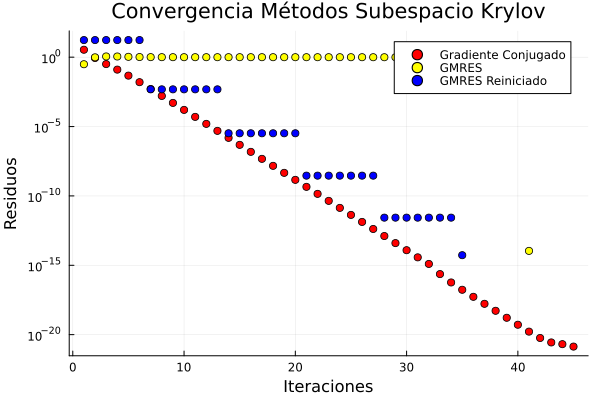

In [215]:
ff = Plots.scatter(norm_cgm, markersize=4, label="Gradiente Conjugado", c="red")
Plots.scatter!(norm_gmres, markersize=4, label="GMRES", c="yellow")
Plots.scatter!(norm_gmres_reiniciado, markersize=4, label="GMRES Reiniciado", c="blue")
plot!(xaxis=("Iteraciones") , yaxis = ("Residuos", :log))
plot!(title="Convergencia Métodos Subespacio Krylov")
plot!(subtitle="Convergencia Métodos Subespacio Krylov")
savefig(ff, "convergenciaSubKrylov")
display(ff)

In [227]:
norm_cgm_precondicionado = cgm_precondicionado_sparse(A,b, precondicionador)
norm_gmres_precondicionado = gmresprecondicionado(A,b, precondicionador, 1e-13)
norm_gmres_reiniciado_precondicionado = gmresprecondicionadoreiniciado(A,b,precondicionador, 1e-13);

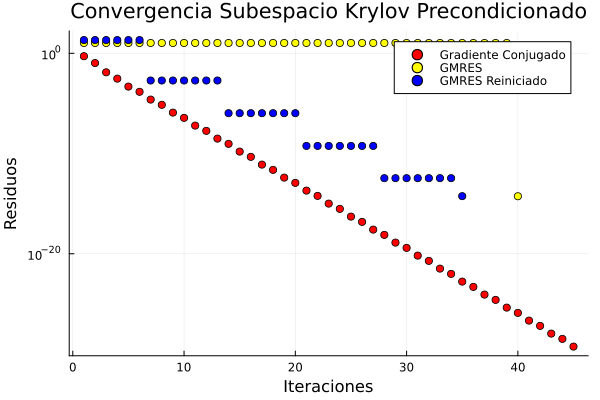

In [228]:
gg = Plots.scatter(norm_cgm_precondicionado, markersize=4, label="Gradiente Conjugado", c="red")
Plots.scatter!(norm_gmres_precondicionado, markersize=4, label="GMRES", c="yellow")
Plots.scatter!(norm_gmres_reiniciado_precondicionado, markersize=4, label="GMRES Reiniciado", c="blue")
plot!(xaxis=("Iteraciones") , yaxis = ("Residuos", :log))
plot!(title="Convergencia Subespacio Krylov Precondicionado")
savefig(gg, "convergenciaSubKrylovPrecondicionado")
display(gg)

In [34]:
graphGmres = Plots.scatter(normres_gmres, markersize=4, label="Plano", c="red", leg=true)
Plots.scatter!(normres_gmrespre, markersize=4, label="Precondicionado", c="yellow")
Plots.scatter!(normres_gmresrei, markersize=4, label="Reiniciado", c="blue")
Plots.scatter!(normres_gmresprerei, markersize=4, label="Precondicionado Reiniciado", c="green")
plot!(xaxis=("iteraciones") , yaxis = ("residuales", :log))
plot!(title="Convergencia del Método del Residuo Mínimo \nGeneralizado")
savefig(graphGmres, "convergenciaGMRES")

"/home/edwin/Documents/WorkSpaces/pesadilla/convergenciaGMRES.png"

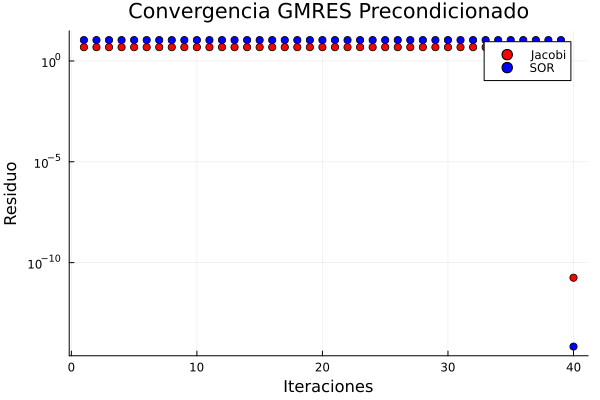

In [247]:
normres_gmrespreJ = gmresprecondicionado(A,b,"Jacobi")
normres_gmrespreS = gmresprecondicionado(A,b,"SOR")
graphGmresPre = Plots.scatter(normres_gmrespreJ, markersize=4, label="Jacobi", c="red", leg=true)
Plots.scatter!(normres_gmrespreS, markersize=4, label="SOR", c="blue")
plot!(xaxis=("Iteraciones") , yaxis = ("Residuo", :log))
plot!(title="Convergencia GMRES Precondicionado")
savefig(graphGmresPre, "convergenciaGMRESPrecondicionadores")
display(graphGmresPre)

In [141]:
N = 128
tA = Matrix{Float64}(undef, N, N)
b = Vector{Float64}(undef, N)
x_0 = zeros(N);
system_matrix_sparse(N, tA)
vector_independent_term(N, b);
A = sparse(tA);

In [146]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
Bgmres = @benchmark gmres(A,b)
BgmresRei = @benchmark gmresreiniciado(A, b)
BgmresPre = @benchmark gmresprecondicionado(A, b, "Gauss-Seidel");
BgmresPreRei = @benchmark gmresprecondicionadoreiniciado(A, b, "Gauss-Seidel");

In [147]:
display(Bgmres)
display(BgmresRei)
display(BgmresPre)
display(BgmresPreRei)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  121.905 μs … 239.562 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     145.076 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   159.926 μs ±  38.712 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                              
  █▅▅▁▁▁▁█▁▁▁▅▅▁▁▁▁▁▁▁▁▁▅▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▅▁▅▁▁▁▁▁▁▅▁▁▁▁▁▁▁▅ ▁
  122 μs           Histogram: frequency by time          240 μs <

 Memory estimate: 775.41 KiB, allocs estimate: 900.

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  68.979 μs … 160.227 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     71.072 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   77.043 μs ±  20.270 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁                                                            
  ██▇▆▁▁▄▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  69 μs           Histogram: frequency by time          160 μs <

 Memory estimate: 476.66 KiB, allocs estimate: 697.

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  122.449 μs … 284.284 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     125.679 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   134.229 μs ±  35.558 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▄▁                                                            
  ███▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  122 μs           Histogram: frequency by time          284 μs <

 Memory estimate: 320.23 KiB, allocs estimate: 665.

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  111.263 μs … 268.781 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     113.576 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   123.312 μs ±  34.927 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁                                                             
  ██▅▁▃▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▁
  111 μs           Histogram: frequency by time          269 μs <

 Memory estimate: 308.14 KiB, allocs estimate: 506.

In [54]:
function backward_substitution(U, b, m)
    x = zeros(m);
    x[m] = b[m] / U[m,m];
    for i in m-1:-1:1
        s = dot(U[i,i+1:m],x[i+1:m]);
        x[i] = (b[i] - s) / U[i,i];
    end
    return x
end

backward_substitution (generic function with 1 method)

In [101]:
dim = N
function gmres_method(A, b, x0, tol)
    k = size(A,1);
    r0 = b - A*x0;
    β = norm(r0);
    e1 = zeros(k+1);
    e1[1] = 1;
    be1 = β*e1;
    H = zeros(k+1, k);
    Q = zeros(k, k+1);
    Q[:,1] = r0/β;
    xe_sol = ones(dim);
    error_method = 0.0;
    normres=[]

    cn = zeros(k);
    sn = zeros(k);
    κ = 0.35;

    for j = 1:k
        vj = A*Q[:,j];
        normvj = norm(vj);
        for i = 1:j
            H[i,j] = dot(vj, Q[:,i]);
            vj = vj - H[i,j]*Q[:,i];
        end
        if norm(vj) / normvj <= κ
            for i = 1:j
                p = dot(Q[:,i],vj);
                vj = vj - p*Q[:,i];
                H[i,j] = H[i,j]+p;
            end
        end
        H[j+1,j] = norm(vj);
        if abs(H[j+1,j]) < tol
            k = j;
            break
        end
        Q[:,j+1] = vj/H[j+1,j];
        for i = 1:j-1
            aux = cn[i]*H[i,j] + sn[i]*H[i+1,j];
            H[i+1,j] = -sn[i]*H[i,j] + cn[i]*H[i+1,j];
            H[i,j] = aux;
        end
        if (abs(H[j,j]) > abs(H[j+1,j]))
            t = H[j+1,j] / H[j,j];
            u = sign(H[j,j]) * sqrt(1 + t^2);
            cn[j] = 1 / u;
            sn[j] = t * cn[j];
        else
            t =  H[j,j] / H[j+1,j];
            u = sign(H[j+1,j]) * sqrt(1 + t^2);
            sn[j] = 1 / u;
            cn[j] = t * sn[j];
        end
        Hjj = H[j,j];
        H[j,j] = cn[j]*Hjj + sn[j]*H[j+1,j];
        H[j+1,j] = -sn[j]*Hjj + cn[j]*H[j+1,j];
        be1[j+1] = -sn[j]*be1[j];
        be1[j] = cn[j]*be1[j];
    end
    for i = 1:k-1
        aux = cn[i]*H[i,k] + sn[i]*H[i+1,k];
        H[i+1,k] = -sn[i]*H[i,k] + cn[i]*H[i+1,k];
        H[i,k] = aux;
    end
    y = backward_substitution(H, be1, k);
    # y = H[1:k,1:k] \ be1[1:k];
    # println(y)
    # println(be1[1:k])
    # println(Q[:,1:k]*y)
    x0 = x0 + Q[:,1:k]*y;
    error_method = norm(x0 - xe_sol) / (norm(x0));
    normres=[normres;error_method]
    # return x0, error_method, k;
    return normres;
end

gmres_method (generic function with 1 method)

In [102]:
    gmres_method(A, b, zeros(length(b)), 1e-5)

127-element Vector{Any}:
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
  ⋮
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815
 17.131841699011815

In [71]:
function gmres_restart_method(A, b, x0, restart, tol)
    m = restart;
    dim = size(A,1);
    # H = Matrix{Float64}(undef,m+1,m);
    # Q = Matrix{Float64}(undef,dim,m+1);
    H = zeros(m+1, m);
    Q = zeros(dim, m+1);
    xp = x0;
    xe_sol = ones(dim);
    error_method = 0.0;
    normres = []

    flag = true;
    k = 0;
    while flag == true
        # println("Reinicio:",k)
        r0 = b - A*xp;
        β = norm(r0);
        Q[:,1] = r0/β;
        e1 = zeros(m+1);
        e1[1] = 1;
        be1 = β*e1;
        cn = zeros(m);
        sn = zeros(m);
        κ = 0.38;
        for j = 1:m
            vj = A*Q[:,j];
            normvj = norm(vj);
            for i = 1:j
                H[i,j] = dot(vj, Q[:,i]);
                vj = vj - H[i,j]*Q[:,i];
            end
            if norm(vj) / normvj <= κ
                for i = 1:j
                    p = dot(Q[:,i],vj);
                    vj = vj - p*Q[:,i];
                    H[i,j] = H[i,j]+p;
                end
            end
            H[j+1,j] = norm(vj);
            if abs(H[j+1,j]) < tol
                println("fin")
                m = j;
                break
            end
            Q[:,j+1] = vj/H[j+1,j];
            for i = 1:j-1
                aux = H[i,j];
                H[i,j] = cn[i]*aux + sn[i]*H[i+1,j];
                H[i+1,j] = -sn[i]*aux + cn[i]*H[i+1,j];
            end
            if (abs(H[j,j]) > abs(H[j+1,j]))
                t = H[j+1,j] / H[j,j];
                u = sign(H[j,j]) * sqrt(1 + t^2);
                cn[j] = 1 / u;
                sn[j] = t * cn[j];
            else
                t =  H[j,j] / H[j+1,j];
                u = sign(H[j+1,j]) * sqrt(1 + t^2);
                sn[j] = 1 / u;
                cn[j] = t * sn[j];
            end
            Hjj = H[j,j];
            H[j,j] = cn[j]*Hjj + sn[j]*H[j+1,j];
            H[j+1,j] = -sn[j]*Hjj + cn[j]*H[j+1,j];
            be1[j+1] = -sn[j]*be1[j];
            be1[j] = cn[j]*be1[j];
        end
        for i = 1:m-1
            aux = H[i,m];
            H[i,m] = cn[i]*aux + sn[i]*H[i+1,m];
            H[i+1,m] = -sn[i]*aux + cn[i]*H[i+1,m];
        end
        #=
        # y = H[1:m,1:m] \ be1[1:m];
        ym = zeros(m);
        ym[m] = be1[m] / H[m,m];
        for i in m-1:-1:1
            s = dot(H[i,i+1:m],ym[i+1:m]);
            ym[i] = (be1[i] - s) / H[i,i];
        end
        =#
        ym = backward_substitution(H, be1, m);
        xm = xp + Q[:,1:m]*ym;
        error_method = norm(xm - xe_sol) / (norm(xm));
        normres=[normres;error_method]
        if error_method < tol
            break;
        end
        xp = xm;
        k += 1;
    end
    # return error_method, k;
    return normres;
end

gmres_restart_method (generic function with 1 method)

In [91]:
gmres_restart_method(A, b, zeros(length(b)), 5, 1e-5)

3-element Vector{Any}:
 0.002688398846918711
 2.932259903429995e-5
 2.8913142433157346e-7